## Final Model for sby_need

Predict sby_need with predicted calls with RandomForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

In [2]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [68]:
# load data
# feature engineering
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1152 non-null   datetime64[ns]
 1   n_sick        1152 non-null   int64         
 2   calls         1152 non-null   float64       
 3   n_duty        1152 non-null   int64         
 4   n_sby         1152 non-null   int64         
 5   sby_need      1152 non-null   float64       
 6   dafted        1152 non-null   float64       
 7   year          1152 non-null   int64         
 8   month         1152 non-null   int64         
 9   day_of_week   1152 non-null   int64         
 10  week          1152 non-null   int64         
 11  day_of_month  1152 non-null   int64         
 12  day_of_year   1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 126.0 KB


In [69]:
# predict calls with RF
# define X and y data
X = df[['year', 'month', 'day_of_week',
       'week', 'day_of_month', 'day_of_year']]
y = df.calls

In [70]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [29]:
# train first model
# no tuned parameters
model = RandomForestRegressor(n_estimators=1000, random_state=6)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [30]:
# calculte RMSE and MSE
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('MSE:', mean_squared_error(y_test, pred))

RMSE: 1236.0084043773995
MSE: 1527716.7756915651


In [71]:
# are alle variables necessary?
# Saving feature names for later use
feature_list = list(X.columns)
pprint(feature_list)

['year', 'month', 'day_of_week', 'week', 'day_of_month', 'day_of_year']


In [72]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day_of_year          Importance: 0.38
Variable: day_of_month         Importance: 0.24
Variable: year                 Importance: 0.14
Variable: day_of_week          Importance: 0.14
Variable: week                 Importance: 0.07
Variable: month                Importance: 0.03


Leave sby_need out:

In [ ]:
# predict calls with RF
# define X and y data
X_no_sby = df[['year', 'month', 'day_of_week',
       'week', 'n_duty', 'day_of_month', 'day_of_year']]
y_no_sby = df.calls

x_train_no_sby, x_test_no_sby = train_test_split(X, 922)
y_train_no_sby, y_test_no_sby = train_test_split(y, 922)

In [ ]:
# remove n-sby
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year'), feature_list.index('day_of_month'), feature_list.index('n_duty'), feature_list.index('month'), feature_list.index('day_of_year')]
train_important = x_train_no_sby[['week', 'year', 'day_of_month', 'n_duty', 'month', 'day_of_year']]
test_important = x_test_no_sby[['week', 'year', 'day_of_month', 'n_duty', 'month', 'day_of_year']]
# Train the random forest
rf_most_important.fit(train_important, y_train_no_sby)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
# calculate RMSE and MSE
print('RMSE:', np.sqrt(mean_squared_error(y_test_no_sby, predictions)))
print('MSE:', mean_squared_error(y_test_no_sby, predictions))

Somehow performence decreased --> we are keeping n_sby

#### Prepare for visualization

In [8]:
# visualization
# Dates of the actual training values
months = X['month']
days = X['day_of_month']
years = X['year']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})

In [9]:
# Dates of the predictions
months = x_test['month']
days = x_test['day_of_month']
years = x_test['year']

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

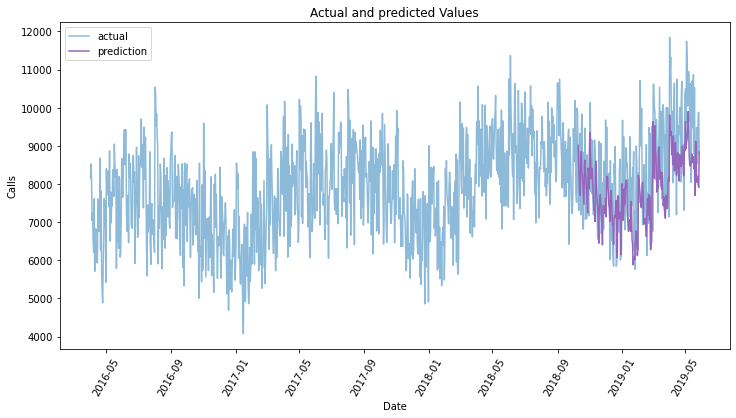

In [10]:
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

### Hyperparameter Tuning

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

In [ ]:
# grid search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

In [ ]:
# pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#model_random.fit(x_train, y_train)

In [ ]:
# view best parameters
#model_random.best_params_

Best parameters:
{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [13]:
# Evaluate Random Search
# To determine if random search yielded a better model, we compare the base model with the best random search model.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    print('Model Performance')
    print('Mean Squared Error: {:0.2f}'.format(mse))
    print('Root Mean Squared Error: {:0.2f}'.format(rmse))
    
    return rmse, mse


In [14]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 6)
base_model.fit(x_train, y_train)
evaluate(base_model, x_test, y_test)

Model Performance
Mean Squared Error: 1526209.78
Root Mean Squared Error: 1235.40


(1235.3986317853141, 1526209.779417026)

In [ ]:
#best_random = model_random.best_estimator_
#evaluate(best_random, x_test, y_test)

Performance got better with the new parameters, now we get even more specific with grid search

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [0, 10, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [1800, 2000, 2200]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
#grid_search.fit(x_train, y_train)

In [ ]:
#grid_search.best_params_

best params:
<br>
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

In [ ]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, x_test, y_test)

--> slightly better

### Make final prediction with new parameters

In [34]:
rf = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt', 
min_samples_leaf=1, min_samples_split=7, n_estimators=1800, random_state=6)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
evaluate(rf, x_test, y_test)


Model Performance
Mean Squared Error: 1475635.44
Root Mean Squared Error: 1214.76


(1214.757358200772, 1475635.4393029185)

In [35]:
# prepare for visualization
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

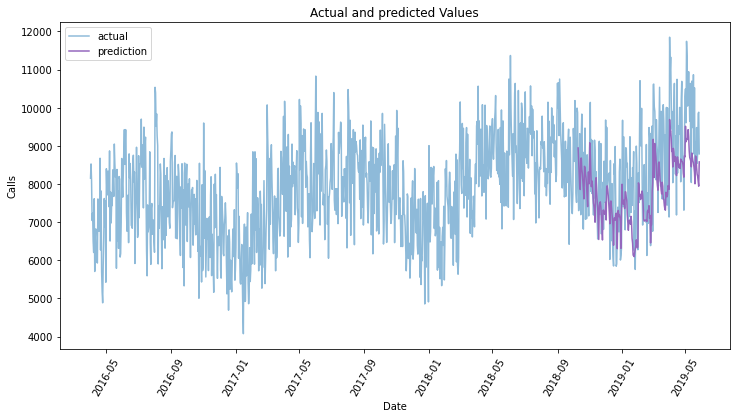

In [36]:
# plot new predictions
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

## Predict sby_need with predicted calls

In [37]:
# create new df with predicted calls
calls_new = pd.concat([df['calls'].iloc[:922], predictions_data['prediction']], axis=0).reset_index(drop=True)
intermediate_df = df.copy()
intermediate_df['calls_new'] = calls_new

In [73]:
# define new X and y
X = intermediate_df[['year', 'month', 'day_of_week', 
       'week', 'n_duty', 'day_of_month', 'day_of_year', 'calls_new']]
y = intermediate_df['sby_need']

['year',
 'month',
 'day_of_week',
 'week',
 'n_duty',
 'day_of_month',
 'day_of_year',
 'calls_new']


In [76]:
# train test split
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)


In [77]:
forest = RandomForestRegressor(n_estimators=1000, random_state=6)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)

In [78]:
## feature importance before final model!!!
feature_list = list(X.columns)
pprint(feature_list)

['year',
 'month',
 'day_of_week',
 'week',
 'n_duty',
 'day_of_month',
 'day_of_year',
 'calls_new']


In [80]:
# Get numerical feature importances
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: calls_new            Importance: 0.88
Variable: year                 Importance: 0.06
Variable: n_duty               Importance: 0.05
Variable: month                Importance: 0.0
Variable: day_of_week          Importance: 0.0
Variable: week                 Importance: 0.0
Variable: day_of_month         Importance: 0.0
Variable: day_of_year          Importance: 0.0


In [40]:
# predict sby_need with QuantileRegressor
quantile = QuantileRegressor(quantile=0.95, alpha=0.25)
quantile.fit(x_train, y_train)
pred = quantile.predict(x_test)
pred = pd.Series(pred)

In [41]:
# eliminate values <0, round to nearest integer
pred = pred.apply(lambda x: 0 if x < 0 else x)
pred = np.round(pred)

In [42]:
# evaluate
evaluate(quantile, x_test, y_test)
print('MAE is:', mean_absolute_error(y_test, pred))

Model Performance
Mean Squared Error: 11761.73
Root Mean Squared Error: 108.45
MAE is: 95.93478260869566


In [43]:
# prepare for visualization
# Dataframe with predictions and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

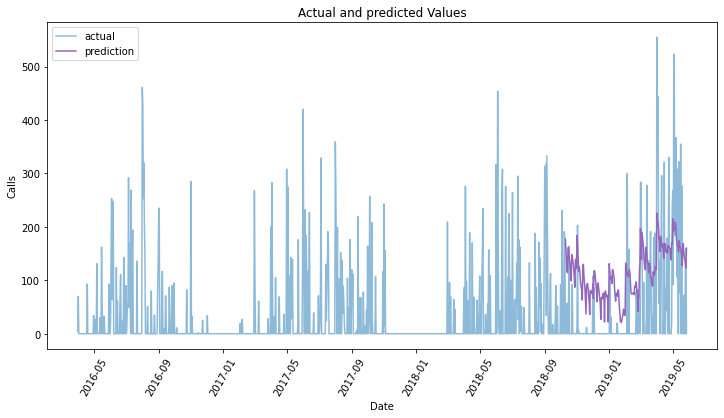

In [44]:
# plot new predictions
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

In [45]:
# create new df with predictions
df_final = intermediate_df.copy()
sby_need_predicted = pd.concat([intermediate_df['sby_need'].iloc[:922], pred], axis=0).reset_index(drop=True)
df_final['sby_need_predicted'] = sby_need_predicted
# create new df for testing timeframe
df_final_eval = df_final[922:]
df_final_eval = df_final_eval.reset_index(drop=True)
df_final_eval.shape

(230, 15)

In [46]:
# check how many times we are understaffed - predicted vs actual
df_final_eval['understaffed'] = np.where(df_final_eval['sby_need_predicted'] < df_final_eval['sby_need'], 1, 0)
df_final_eval['overstaffed'] = np.where(df_final_eval['sby_need_predicted'] > df_final_eval['sby_need'], 1, 0)
df_final_eval['exact_match'] = np.where(df_final_eval['sby_need_predicted'] == df_final_eval['sby_need'], 1, 0)
understaffed = df_final_eval['understaffed'].sum()
overstaffed = df_final_eval['overstaffed'].sum()
exact_match = df_final_eval['exact_match'].sum()
print('Understaffed: {} days,'.format(understaffed), 'Percent: {}%'.format(understaffed/len(df_final_eval)*100))
print('Overstaffed: {} days,'.format(overstaffed), 'Percent: {}%'.format(overstaffed/len(df_final_eval)*100))
print('Exact match: {} days,'.format(exact_match), 'Percent: {}%'.format(exact_match/len(df_final_eval)*100))

Understaffed: 39 days, Percent: 16.956521739130434%
Overstaffed: 191 days, Percent: 83.04347826086956%
Exact match: 0 days, Percent: 0.0%


In [47]:
# check baseline
df_baseline = df_final_eval.copy()
df_baseline['understaffed'] = np.where(df_baseline['n_sby'] < df_baseline['sby_need'], 1, 0)
df_baseline['overstaffed'] = np.where(df_baseline['n_sby'] > df_baseline['sby_need'], 1, 0)
df_baseline['exact_match'] = np.where(df_baseline['n_sby'] == df_baseline['sby_need'], 1, 0)
understaffed_baseline = df_baseline['understaffed'].sum()
overstaffed_baseline = df_baseline['overstaffed'].sum()
exact_match_baseline = df_baseline['exact_match'].sum()
print('Understaffed baseline: {} days'.format(understaffed_baseline), 'Percent: {}%'.format(understaffed_baseline/len(df_baseline)*100))
print('Overstaffed baseline: {} days'.format(overstaffed_baseline), 'Percent: {}%'.format(overstaffed_baseline/len(df_baseline)*100))
print('Exact match baseline: {} days'.format(exact_match_baseline), 'Percent: {}%'.format(exact_match_baseline/len(df_baseline)*100))

Understaffed baseline: 48 days Percent: 20.869565217391305%
Overstaffed baseline: 182 days Percent: 79.13043478260869%
Exact match baseline: 0 days Percent: 0.0%


### Factor in seasonality, encode months

In [48]:
df_final['january'] = np.where(df_final['month'] == 1, 1, 0)
df_final['february'] = np.where(df_final['month'] == 2, 1, 0)
df_final['march'] = np.where(df_final['month'] == 3, 1, 0)
df_final['april'] = np.where(df_final['month'] == 4, 1, 0)
df_final['may'] = np.where(df_final['month'] == 5, 1, 0)
df_final['june'] = np.where(df_final['month'] == 6, 1, 0)
df_final['july'] = np.where(df_final['month'] == 7, 1, 0)
df_final['august'] = np.where(df_final['month'] == 8, 1, 0)
df_final['september'] = np.where(df_final['month'] == 9, 1, 0)
df_final['october'] = np.where(df_final['month'] == 10, 1, 0)
df_final['november'] = np.where(df_final['month'] == 11, 1, 0)
df_final['december'] = np.where(df_final['month'] == 12, 1, 0)


In [49]:
# encode seasons
df_final['winter'] = np.where((df_final['month'] == 12) | (df_final['month'] == 1) | (df_final['month'] == 2), 1, 0)
df_final['spring'] = np.where((df_final['month'] == 3) | (df_final['month'] == 4) | (df_final['month'] == 5), 1, 0)
df_final['summer'] = np.where((df_final['month'] == 6) | (df_final['month'] == 7) | (df_final['month'] == 8), 1, 0)
df_final['fall'] = np.where((df_final['month'] == 9) | (df_final['month'] == 10) | (df_final['month'] == 11), 1, 0)

In [50]:
# encode year
df_final['2016'] = np.where(df_final['year'] == 2016, 1, 0)
df_final['2017'] = np.where(df_final['year'] == 2017, 1, 0)
df_final['2018'] = np.where(df_final['year'] == 2018, 1, 0)
df_final['2019'] = np.where(df_final['year'] == 2019, 1, 0)



In [51]:
# encode day of week
df_final['monday'] = np.where(df_final['day_of_week'] == 0, 1, 0)
df_final['tuesday'] = np.where(df_final['day_of_week'] == 1, 1, 0)
df_final['wednesday'] = np.where(df_final['day_of_week'] == 2, 1, 0)
df_final['thursday'] = np.where(df_final['day_of_week'] == 3, 1, 0)
df_final['friday'] = np.where(df_final['day_of_week'] == 4, 1, 0)
df_final['saturday'] = np.where(df_final['day_of_week'] == 5, 1, 0)
df_final['sunday'] = np.where(df_final['day_of_week'] == 6, 1, 0)


In [52]:
# drop encoded columns
df_final = df_final.drop(['month', 'day_of_week', 'year'], axis=1)

In [53]:
df_final.columns

Index(['date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted',
       'week', 'day_of_month', 'day_of_year', 'calls_new',
       'sby_need_predicted', 'january', 'february', 'march', 'april', 'may',
       'june', 'july', 'august', 'september', 'october', 'november',
       'december', 'winter', 'spring', 'summer', 'fall', '2016', '2017',
       '2018', '2019', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday'],
      dtype='object')

In [54]:
df_final.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,week,day_of_month,day_of_year,...,2017,2018,2019,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,2016-04-01,73,8154.0,1700,90,4.0,0.0,13,1,92,...,0,0,0,0,0,0,0,1,0,0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0,13,2,93,...,0,0,0,0,0,0,0,0,1,0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0,13,3,94,...,0,0,0,0,0,0,0,0,0,1
3,2016-04-04,71,7044.0,1700,90,0.0,0.0,14,4,95,...,0,0,0,1,0,0,0,0,0,0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0,14,5,96,...,0,0,0,0,1,0,0,0,0,0


In [55]:
# make predictions again
# define new X and y
X = df_final[['n_duty', 'n_sby',
       'week', 'day_of_month', 'day_of_year', 'calls_new',
    'january', 'february', 'march', 'april', 'may',
       'june', 'july', 'august', 'september', 'october', 'november',
       'december', '2016', '2017', '2018', '2019', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'sunday']]
y = df_final['sby_need']

In [56]:
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [57]:
quant_regression = QuantileRegressor(quantile=0.95, alpha=0.25).fit(x_train, y_train)

In [58]:
pred = quant_regression.predict(x_test)
pred = pd.Series(pred)
# set values below 0 to 0
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [60]:
print('MSE of the lasso model is:' , mean_squared_error(y_test, pred))
# MSE of the improved model is: 8995.414326160024
print('MAE of the lasso model is:' , mean_absolute_error(y_test, pred))
print('RMSE of the lasso model is:' , np.sqrt(mean_squared_error(y_test, pred)))

MSE of the lasso model is: 11761.728799434186
MAE of the lasso model is: 95.97488876850585
RMSE of the lasso model is: 108.451504366856


In [ ]:
# Build the Lasso Regression model for the best lamda
lassoModelChosen = Lasso(alpha = 0)
lassoModelChosen.fit(x_train, y_train)

In [ ]:
pred = lassoModelChosen.predict(x_test)
pred = pd.Series(pred)
# set values below 0 to 0
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [ ]:
print('MSE of the lasso model is:' , mean_squared_error(y_test, pred))
# MSE of the improved model is: 8995.414326160024
print('MAE of the lasso model is:' , mean_absolute_error(y_test, pred))


In [ ]:
print(X.columns)
lassoModelChosen.coef_

In [ ]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [ ]:
pred = pd.Series(pred)
# set values below 0 to 0
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [ ]:
print('MSE of the linear regression model is:' , mean_squared_error(y_test, pred))
print('MAE of the linear regression model is:' , mean_absolute_error(y_test, pred))

In [ ]:
# Linear Regression
model.coef_

In [61]:
# one hot encode day of year
one_hot_day_of_year = pd.get_dummies(df_final['day_of_year'], prefix='day_of_year')

In [62]:
merged = df_final.join(one_hot_day_of_year)

In [ ]:
lst = list(merged.columns)
lst

In [63]:
# new models
X = merged[[
 'n_duty',
 'n_sby',
 'week',
 'day_of_month',
 'calls_new',
 'january',
 'february',
 'march',
 'april',
 'may',
 'june',
 'july',
 'august',
 'september',
 'october',
 'november',
 'december',
 'winter',
 'spring',
 'summer',
 'fall',
 '2016',
 '2017',
 '2018',
 '2019',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday',
 'day_of_year_1',
 'day_of_year_2',
 'day_of_year_3',
 'day_of_year_4',
 'day_of_year_5',
 'day_of_year_6',
 'day_of_year_7',
 'day_of_year_8',
 'day_of_year_9',
 'day_of_year_10',
 'day_of_year_11',
 'day_of_year_12',
 'day_of_year_13',
 'day_of_year_14',
 'day_of_year_15',
 'day_of_year_16',
 'day_of_year_17',
 'day_of_year_18',
 'day_of_year_19',
 'day_of_year_20',
 'day_of_year_21',
 'day_of_year_22',
 'day_of_year_23',
 'day_of_year_24',
 'day_of_year_25',
 'day_of_year_26',
 'day_of_year_27',
 'day_of_year_28',
 'day_of_year_29',
 'day_of_year_30',
 'day_of_year_31',
 'day_of_year_32',
 'day_of_year_33',
 'day_of_year_34',
 'day_of_year_35',
 'day_of_year_36',
 'day_of_year_37',
 'day_of_year_38',
 'day_of_year_39',
 'day_of_year_40',
 'day_of_year_41',
 'day_of_year_42',
 'day_of_year_43',
 'day_of_year_44',
 'day_of_year_45',
 'day_of_year_46',
 'day_of_year_47',
 'day_of_year_48',
 'day_of_year_49',
 'day_of_year_50',
 'day_of_year_51',
 'day_of_year_52',
 'day_of_year_53',
 'day_of_year_54',
 'day_of_year_55',
 'day_of_year_56',
 'day_of_year_57',
 'day_of_year_58',
 'day_of_year_59',
 'day_of_year_60',
 'day_of_year_61',
 'day_of_year_62',
 'day_of_year_63',
 'day_of_year_64',
 'day_of_year_65',
 'day_of_year_66',
 'day_of_year_67',
 'day_of_year_68',
 'day_of_year_69',
 'day_of_year_70',
 'day_of_year_71',
 'day_of_year_72',
 'day_of_year_73',
 'day_of_year_74',
 'day_of_year_75',
 'day_of_year_76',
 'day_of_year_77',
 'day_of_year_78',
 'day_of_year_79',
 'day_of_year_80',
 'day_of_year_81',
 'day_of_year_82',
 'day_of_year_83',
 'day_of_year_84',
 'day_of_year_85',
 'day_of_year_86',
 'day_of_year_87',
 'day_of_year_88',
 'day_of_year_89',
 'day_of_year_90',
 'day_of_year_91',
 'day_of_year_92',
 'day_of_year_93',
 'day_of_year_94',
 'day_of_year_95',
 'day_of_year_96',
 'day_of_year_97',
 'day_of_year_98',
 'day_of_year_99',
 'day_of_year_100',
 'day_of_year_101',
 'day_of_year_102',
 'day_of_year_103',
 'day_of_year_104',
 'day_of_year_105',
 'day_of_year_106',
 'day_of_year_107',
 'day_of_year_108',
 'day_of_year_109',
 'day_of_year_110',
 'day_of_year_111',
 'day_of_year_112',
 'day_of_year_113',
 'day_of_year_114',
 'day_of_year_115',
 'day_of_year_116',
 'day_of_year_117',
 'day_of_year_118',
 'day_of_year_119',
 'day_of_year_120',
 'day_of_year_121',
 'day_of_year_122',
 'day_of_year_123',
 'day_of_year_124',
 'day_of_year_125',
 'day_of_year_126',
 'day_of_year_127',
 'day_of_year_128',
 'day_of_year_129',
 'day_of_year_130',
 'day_of_year_131',
 'day_of_year_132',
 'day_of_year_133',
 'day_of_year_134',
 'day_of_year_135',
 'day_of_year_136',
 'day_of_year_137',
 'day_of_year_138',
 'day_of_year_139',
 'day_of_year_140',
 'day_of_year_141',
 'day_of_year_142',
 'day_of_year_143',
 'day_of_year_144',
 'day_of_year_145',
 'day_of_year_146',
 'day_of_year_147',
 'day_of_year_148',
 'day_of_year_149',
 'day_of_year_150',
 'day_of_year_151',
 'day_of_year_152',
 'day_of_year_153',
 'day_of_year_154',
 'day_of_year_155',
 'day_of_year_156',
 'day_of_year_157',
 'day_of_year_158',
 'day_of_year_159',
 'day_of_year_160',
 'day_of_year_161',
 'day_of_year_162',
 'day_of_year_163',
 'day_of_year_164',
 'day_of_year_165',
 'day_of_year_166',
 'day_of_year_167',
 'day_of_year_168',
 'day_of_year_169',
 'day_of_year_170',
 'day_of_year_171',
 'day_of_year_172',
 'day_of_year_173',
 'day_of_year_174',
 'day_of_year_175',
 'day_of_year_176',
 'day_of_year_177',
 'day_of_year_178',
 'day_of_year_179',
 'day_of_year_180',
 'day_of_year_181',
 'day_of_year_182',
 'day_of_year_183',
 'day_of_year_184',
 'day_of_year_185',
 'day_of_year_186',
 'day_of_year_187',
 'day_of_year_188',
 'day_of_year_189',
 'day_of_year_190',
 'day_of_year_191',
 'day_of_year_192',
 'day_of_year_193',
 'day_of_year_194',
 'day_of_year_195',
 'day_of_year_196',
 'day_of_year_197',
 'day_of_year_198',
 'day_of_year_199',
 'day_of_year_200',
 'day_of_year_201',
 'day_of_year_202',
 'day_of_year_203',
 'day_of_year_204',
 'day_of_year_205',
 'day_of_year_206',
 'day_of_year_207',
 'day_of_year_208',
 'day_of_year_209',
 'day_of_year_210',
 'day_of_year_211',
 'day_of_year_212',
 'day_of_year_213',
 'day_of_year_214',
 'day_of_year_215',
 'day_of_year_216',
 'day_of_year_217',
 'day_of_year_218',
 'day_of_year_219',
 'day_of_year_220',
 'day_of_year_221',
 'day_of_year_222',
 'day_of_year_223',
 'day_of_year_224',
 'day_of_year_225',
 'day_of_year_226',
 'day_of_year_227',
 'day_of_year_228',
 'day_of_year_229',
 'day_of_year_230',
 'day_of_year_231',
 'day_of_year_232',
 'day_of_year_233',
 'day_of_year_234',
 'day_of_year_235',
 'day_of_year_236',
 'day_of_year_237',
 'day_of_year_238',
 'day_of_year_239',
 'day_of_year_240',
 'day_of_year_241',
 'day_of_year_242',
 'day_of_year_243',
 'day_of_year_244',
 'day_of_year_245',
 'day_of_year_246',
 'day_of_year_247',
 'day_of_year_248',
 'day_of_year_249',
 'day_of_year_250',
 'day_of_year_251',
 'day_of_year_252',
 'day_of_year_253',
 'day_of_year_254',
 'day_of_year_255',
 'day_of_year_256',
 'day_of_year_257',
 'day_of_year_258',
 'day_of_year_259',
 'day_of_year_260',
 'day_of_year_261',
 'day_of_year_262',
 'day_of_year_263',
 'day_of_year_264',
 'day_of_year_265',
 'day_of_year_266',
 'day_of_year_267',
 'day_of_year_268',
 'day_of_year_269',
 'day_of_year_270',
 'day_of_year_271',
 'day_of_year_272',
 'day_of_year_273',
 'day_of_year_274',
 'day_of_year_275',
 'day_of_year_276',
 'day_of_year_277',
 'day_of_year_278',
 'day_of_year_279',
 'day_of_year_280',
 'day_of_year_281',
 'day_of_year_282',
 'day_of_year_283',
 'day_of_year_284',
 'day_of_year_285',
 'day_of_year_286',
 'day_of_year_287',
 'day_of_year_288',
 'day_of_year_289',
 'day_of_year_290',
 'day_of_year_291',
 'day_of_year_292',
 'day_of_year_293',
 'day_of_year_294',
 'day_of_year_295',
 'day_of_year_296',
 'day_of_year_297',
 'day_of_year_298',
 'day_of_year_299',
 'day_of_year_300',
 'day_of_year_301',
 'day_of_year_302',
 'day_of_year_303',
 'day_of_year_304',
 'day_of_year_305',
 'day_of_year_306',
 'day_of_year_307',
 'day_of_year_308',
 'day_of_year_309',
 'day_of_year_310',
 'day_of_year_311',
 'day_of_year_312',
 'day_of_year_313',
 'day_of_year_314',
 'day_of_year_315',
 'day_of_year_316',
 'day_of_year_317',
 'day_of_year_318',
 'day_of_year_319',
 'day_of_year_320',
 'day_of_year_321',
 'day_of_year_322',
 'day_of_year_323',
 'day_of_year_324',
 'day_of_year_325',
 'day_of_year_326',
 'day_of_year_327',
 'day_of_year_328',
 'day_of_year_329',
 'day_of_year_330',
 'day_of_year_331',
 'day_of_year_332',
 'day_of_year_333',
 'day_of_year_334',
 'day_of_year_335',
 'day_of_year_336',
 'day_of_year_337',
 'day_of_year_338',
 'day_of_year_339',
 'day_of_year_340',
 'day_of_year_341',
 'day_of_year_342',
 'day_of_year_343',
 'day_of_year_344',
 'day_of_year_345',
 'day_of_year_346',
 'day_of_year_347',
 'day_of_year_348',
 'day_of_year_349',
 'day_of_year_350',
 'day_of_year_351',
 'day_of_year_352',
 'day_of_year_353',
 'day_of_year_354',
 'day_of_year_355',
 'day_of_year_356',
 'day_of_year_357',
 'day_of_year_358',
 'day_of_year_359',
 'day_of_year_360',
 'day_of_year_361',
 'day_of_year_362',
 'day_of_year_363',
 'day_of_year_364',
 'day_of_year_365',
 'day_of_year_366']]

y = merged.sby_need

In [64]:
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [65]:
# Build the Lasso Regression model for the best lamda
quantile_encoded = QuantileRegressor(quantile=0.95, alpha=0.25)
quantile_encoded.fit(x_train, y_train)

QuantileRegressor(alpha=0.25, quantile=0.95)

In [66]:
pred = quantile_encoded.predict(x_test)
pred = pd.Series(pred)
# set values below 0 to 0
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [67]:
print('MSE of the lasso model is:' , mean_squared_error(y_test, pred))
# MSE of the improved model is: 8995.414326160024
print('MAE of the lasso model is:' , mean_absolute_error(y_test, pred))
print('RMSE of the lasso model is:' , np.sqrt(mean_squared_error(y_test, pred)))


MSE of the lasso model is: 12976.27712548156
MAE of the lasso model is: 101.99394277515549
RMSE of the lasso model is: 113.91346331966894


In [ ]:
lassoModelChosen.coef_

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred = pd.Series(pred)
# set values below 0 to 0
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [ ]:
print('MSE of the LR model is:' , mean_squared_error(y_test, pred))

print('MAE of the LR model is:' , mean_absolute_error(y_test, pred))

In [ ]:
model.coef_

In [ ]:
quantile = QuantileRegressor(quantile=0.95, alpha=0.25).fit(x_train, y_train)
pred = quantile.predict(x_test)
pred = pd.Series(pred)

In [ ]:
# eliminate values <0, round to nearest integer
pred = pred.apply(lambda x: 0 if x < 0 else x)
pred = np.round(pred)

In [ ]:
print('MSE of the quantile model is:' , mean_squared_error(y_test, pred))
print('MAE of the quantile model is:' , mean_absolute_error(y_test, pred))